In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.0+cu121


In [2]:
#Get the current working directory
cwd = os.getcwd()
file_path = cwd + '/points_50.csv'

In [3]:
df=pd.read_csv(file_path)

#Round the values of the dataset to 4 decimal places
df = df.round(4)

#Add a column to use as index from 0 to the length of the dataset
df['n_label'] = range(0, len(df))

#delete the column p_label
df = df.drop('p_label', axis=1)

df.head()

,x,y,z,N_side,N_layer,t_label,phi,eta,q,pt,d0,z0,n_label
0,-0.1120,-9.9682,-6.3331,8,1,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.022,0
1,-0.4144,-19.8918,-12.6639,8,2,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.022,1
2,-0.6930,-29.8162,-18.9948,8,3,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.022,2
3,-0.9483,-39.7538,-25.3337,8,4,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.022,3
4,-1.1794,-49.6794,-31.6646,8,5,T0,-1.6049,-0.6008,-1,48.2712,0.2156,0.022,4


In [4]:
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

In [5]:
#Empty hetero graph 
data=HeteroData()

## Add nodes

In [6]:
#node names
nodes_s=df['n_label'].values
nodes_t=df['n_label'].values

In [7]:
#Add nodes to the graph
data['source'].node_id = torch.tensor(nodes_s, dtype=torch.long)
data['target'].node_id = torch.tensor(nodes_t, dtype=torch.long)

In [8]:
#Add node attributes, in this case the position of the points
data['source'].x = Tensor(df[['x', 'y', 'z']].values)
data['target'].x = Tensor(df[['x', 'y', 'z']].values)

In [9]:
data

HeteroData(
  source={
    node_id=[500],
    x=[500, 3],
  },
  target={
    node_id=[500],
    x=[500, 3],
  }
)

## Add edges

In [10]:
edge_path = cwd + '/grap_50.csv'

# Importing the dataset
df_edge = pd.read_csv(edge_path)

In [11]:
#Change weight column, where 0.5 to 0
df_edge['weight'] = df_edge['weight'].replace(0.5, 0)

In [12]:
edge_index = torch.tensor([df_edge['Source'], df_edge['Target']], dtype=torch.long)

In [13]:
data['source', 'weight', 'target'].edge_index = edge_index

In [14]:
data

HeteroData(
  source={
    node_id=[500],
    x=[500, 3],
  },
  target={
    node_id=[500],
    x=[500, 3],
  },
  (source, weight, target)={ edge_index=[2, 692] }
)

In [15]:
#edge attributes
weight_val = torch.from_numpy(df_edge['weight'].values).to(torch.float)

In [16]:
data['source', 'weight', 'target'].edge_label=weight_val

In [17]:
data

HeteroData(
  source={
    node_id=[500],
    x=[500, 3],
  },
  target={
    node_id=[500],
    x=[500, 3],
  },
  (source, weight, target)={
    edge_index=[2, 692],
    edge_label=[692],
  }
)

In [18]:
#check if the data is valid
data.validate(raise_on_error=True)

True

In [19]:
import torch_geometric.transforms as T
data = T.ToUndirected()(data)

In [20]:
del data['target', 'rev_weight', 'source'].edge_label

In [21]:
print(data.validate(raise_on_error=True))
data

True


HeteroData(
  source={
    node_id=[500],
    x=[500, 3],
  },
  target={
    node_id=[500],
    x=[500, 3],
  },
  (source, weight, target)={
    edge_index=[2, 692],
    edge_label=[692],
  },
  (target, rev_weight, source)={ edge_index=[2, 692] }
)

In [46]:
#save data into .pt file
torch.save(data, 'data_50.pt')

In [22]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('source', 'weight', 'target')],
    rev_edge_types=[('target', 'rev_weight', 'source')],
)(data)

In [23]:
train_data

HeteroData(
  source={
    node_id=[500],
    x=[500, 3],
  },
  target={
    node_id=[500],
    x=[500, 3],
  },
  (source, weight, target)={
    edge_index=[2, 554],
    edge_label=[554],
    edge_label_index=[2, 554],
  },
  (target, rev_weight, source)={ edge_index=[2, 554] }
)

## Model

In [24]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['source'][row], z_dict['target'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (source__weight__target): SAGEConv((-1, -1), 32, aggr=mean)
      (target__rev_weight__source): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (source__weight__target): SAGEConv((-1, -1), 32, aggr=mean)
      (target__rev_weight__source): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [25]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['source', 'target'].edge_label_index)
    target = train_data['source', 'target'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['source', 'target'].edge_label_index)
    pred = pred.clamp(min=0, max=1)
    target = data['source', 'target'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [26]:
for epoch in range(1, 301):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 19.2540, Train: 0.8307, Val: 0.8955
Epoch: 002, Loss: 911.3440, Train: 0.7092, Val: 0.7532
Epoch: 003, Loss: 111.7740, Train: 0.5784, Val: 0.6626
Epoch: 004, Loss: 36.1454, Train: 0.5444, Val: 0.6546
Epoch: 005, Loss: 60.6273, Train: 0.6654, Val: 0.6594
Epoch: 006, Loss: 32.1431, Train: 0.7006, Val: 0.7489
Epoch: 007, Loss: 7.2293, Train: 0.8391, Val: 0.8390
Epoch: 008, Loss: 8.5974, Train: 0.8382, Val: 0.8728
Epoch: 009, Loss: 20.1188, Train: 0.8131, Val: 0.8533
Epoch: 010, Loss: 18.7385, Train: 0.7602, Val: 0.7478
Epoch: 011, Loss: 7.2755, Train: 0.6218, Val: 0.6130
Epoch: 012, Loss: 2.2397, Train: 0.5545, Val: 0.5448
Epoch: 013, Loss: 6.2938, Train: 0.5298, Val: 0.5233
Epoch: 014, Loss: 8.5234, Train: 0.5318, Val: 0.5680
Epoch: 015, Loss: 5.3990, Train: 0.5688, Val: 0.6816
Epoch: 016, Loss: 1.5719, Train: 0.7023, Val: 0.8098
Epoch: 017, Loss: 1.0588, Train: 0.7959, Val: 0.8737
Epoch: 018, Loss: 3.4331, Train: 0.8124, Val: 0.8786
Epoch: 019, Loss: 4.7852, Train: 0.8

In [27]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['source', 'target'].edge_label_index)
    pred = pred.clamp(min=0, max=1)
    target = test_data['source', 'target'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

sour = test_data['source', 'target'].edge_label_index[0].cpu().numpy()
tar = test_data['source', 'target'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

res=pd.DataFrame({'source': sour, 'target': tar, 'pred': pred, 'compare': target})

Test RMSE: 0.4376


In [28]:
#Add a new column if pred is greater or equal than 0.5 then 1 else 0.5
res['weight'] = np.where(res['pred']>0.5, 1, 0)

In [29]:
res.head()

,source,target,pred,compare,weight
0,127,128,0.409241,1.0,0
1,271,62,0.600271,0.0,1
2,371,472,0.302245,0.0,0
3,6,7,0.542166,1.0,1
4,206,207,1.000000,1.0,1


In [30]:
#compare column rating_1 with target and if they are equal add up
cont=0
for i in res.itertuples():
    if i.compare == i.weight:
        cont+=1

#Calculate the accuracy
accuracy = cont/len(res)
print('Accuracy:', accuracy)
print('Number of correct predictions:', cont)

Accuracy: 0.6811594202898551
Number of correct predictions: 47


In [31]:
res_1 = res[res['compare']==1]
res_0 = res[res['compare']==0]

In [32]:
#compare column rating_1 with target and if they are equal add up
cont=0
for i in res_0.itertuples():
    if i.compare == i.weight:
        cont+=1

#Calculate the accuracy
accuracy = cont/len(res_0)
print('Accuracy:', accuracy)
print('Number of correct predictions:', cont)

print("--------------------------------------------")

#compare column rating_1 with target and if they are equal add up
cont=0
for i in res_1.itertuples():
    if i.compare == i.weight:
        cont+=1

#Calculate the accuracy
accuracy = cont/len(res_1)
print('Accuracy:', accuracy)
print('Number of correct predictions:', cont)

Accuracy: 0.6
Number of correct predictions: 12
--------------------------------------------
Accuracy: 0.7142857142857143
Number of correct predictions: 35


## New Graph

In [33]:
#read a new csv file
file_test = cwd + '/points_10.csv'
df_test=pd.read_csv(file_test, sep=',')

#Round the values of the dataset to 4 decimal places
df_test = df_test.round(4)

#Add a column to use as index from 0 to the length of the dataset
df_test['n_label'] = range(0, len(df_test))

#delete the column p_label
df_test = df_test.drop('p_label', axis=1)

In [34]:
data_10=HeteroData()

nodes_s=df_test['n_label'].values
nodes_t=df_test['n_label'].values

data_10['source'].node_id = torch.tensor(nodes_s, dtype=torch.long)
data_10['target'].node_id = torch.tensor(nodes_t, dtype=torch.long)

data_10['source'].x = Tensor(df_test[['x', 'y', 'z']].values)
data_10['target'].x = Tensor(df_test[['x', 'y', 'z']].values)

In [35]:
edge_test_path = cwd + '/grap_10.csv'

# Importing the dataset
df_test_edge = pd.read_csv(edge_test_path)

#Change weight column, where 0.5 to 0
df_test_edge['weight'] = df_test_edge['weight'].replace(0.5, 0)

edge_index_test = torch.tensor([df_test_edge['Source'], df_test_edge['Target']], dtype=torch.long)

data_10['source', 'weight', 'target'].edge_index = edge_index_test

weight_test = torch.from_numpy(df_test_edge['weight'].values).to(torch.float)

data_10['source', 'weight', 'target'].edge_label=weight_test

In [36]:
data_10= T.ToUndirected()(data_10)
del data_10['target', 'rev_weight', 'source'].edge_label

In [37]:
print(data_10.validate(raise_on_error=True))
data_10

True


HeteroData(
  source={
    node_id=[100],
    x=[100, 3],
  },
  target={
    node_id=[100],
    x=[100, 3],
  },
  (source, weight, target)={
    edge_index=[2, 107],
    edge_label=[107],
  },
  (target, rev_weight, source)={ edge_index=[2, 107] }
)

In [38]:
with torch.no_grad():
    data_10 = data_10.to(device)
    pred = model(data_10.x_dict, data_10.edge_index_dict,
                 data_10['source', 'target'].edge_index)
    pred = pred.clamp(min=0, max=1)
    target = data_10['source', 'target'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

sour = data_10['source', 'target'].edge_index[0].cpu().numpy()
tar = data_10['source', 'target'].edge_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

res=pd.DataFrame({'source': sour, 'target': tar, 'pred': pred, 'compare': target})

Test RMSE: 0.4612


In [39]:
#Add a new column if pred is greater or equal than 0.5 then 1 else 0.5
res['weight'] = np.where(res['pred']>0.5, 1, 0)

#compare column rating_1 with target and if they are equal add up
cont=0
for i in res.itertuples():
    if i.compare == i.weight:
        cont+=1

#Calculate the accuracy
accuracy = cont/len(res)
print('Accuracy:', accuracy)
print('Number of correct predictions:', cont)

Accuracy: 0.7476635514018691
Number of correct predictions: 80


In [40]:
res_1 = res[res['weight']==1]
res_0 = res[res['weight']==0]

In [42]:
#compare column rating_1 with target and if they are equal add up
print("values of weight 0")
cont=0
for i in res_0.itertuples():
    if i.compare == i.weight:
        cont+=1

#Calculate the accuracy
accuracy = cont/len(res_0)
print('Accuracy:', accuracy)
print('Number of correct predictions:', cont)

print("--------------------------------------------")
print("values of weight 1")
cont=0
for i in res_1.itertuples():
    if i.compare == i.weight:
        cont+=1

#Calculate the accuracy
accuracy = cont/len(res_1)
print('Accuracy:', accuracy)
print('Number of correct predictions:', cont)

values of weight 0
Accuracy: 0.26666666666666666
Number of correct predictions: 4
--------------------------------------------
values of weight 1
Accuracy: 0.8260869565217391
Number of correct predictions: 76


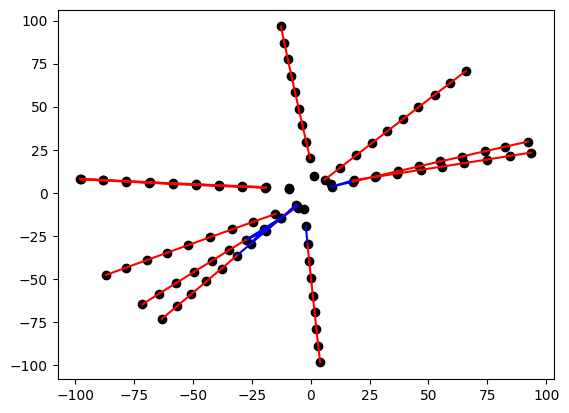

In [48]:
plt.plot(df_test['x'], df_test['y'], 'o', color='black')
for i in res.itertuples():
    if i.weight == 1:
        plt.plot([df_test['x'][i.source], df_test['x'][i.target]], [df_test['y'][i.source], df_test['y'][i.target]], color='red')
    else:
        plt.plot([df_test['x'][i.source], df_test['x'][i.target]], [df_test['y'][i.source], df_test['y'][i.target]], color='blue')
plt.show()


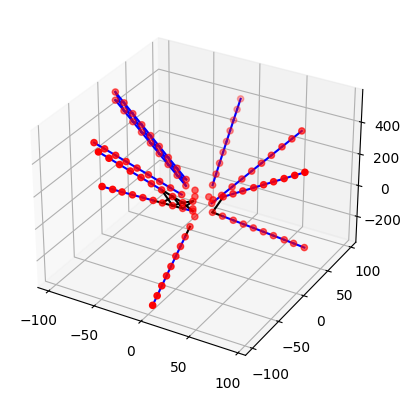

In [45]:
#plot the 3D points, add lines between the points and the color of the line will be the weight
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#plot the points
ax.scatter(df_test['x'], df_test['y'], df_test['z'], c='r', marker='o')

#plot the lines
for i in res.itertuples():
    if i.weight == 1:
        ax.plot([df_test['x'][i.source], df_test['x'][i.target]], [df_test['y'][i.source], df_test['y'][i.target]], [df_test['z'][i.source], df_test['z'][i.target]], c='b')
    else:
        ax.plot([df_test['x'][i.source], df_test['x'][i.target]], [df_test['y'][i.source], df_test['y'][i.target]], [df_test['z'][i.source], df_test['z'][i.target]], c='black')

plt.show()